<a href="https://colab.research.google.com/github/Chirag314/Interpretable-machine-learning/blob/main/CVD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
#import machine_learning_datasets as mldatasets
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
!pip install kaggle
!mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [6]:
!kaggle datasets download -d sulianova/cardiovascular-disease-dataset -f cardio_train.csv
!unzip cardio_train.csv.zip

  0% 0.00/742k [00:00<?, ?B/s]
100% 742k/742k [00:00<00:00, 44.4MB/s]
Archive:  cardio_train.csv.zip
  inflating: cardio_train.csv        


In [7]:
train = pd.read_csv('/content/cardio_train.csv', sep=';',index_col='id')

In [8]:
train.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.9 MB


In [10]:
#Age is measured in days here so we should convert in years
train['age']=train['age']/365.24

In [11]:
train.describe(percentiles=[.01,.99]).transpose()

,count,mean,std,min,1%,50%,99%,max
age,70000.0,53.304309,6.755152,29.564122,39.606834,53.945351,64.311138,64.924433
gender,70000.0,1.349571,0.476838,1.000000,1.000000,1.000000,2.000000,2.000000
height,70000.0,164.359229,8.210126,55.000000,147.000000,165.000000,184.000000,250.000000
weight,70000.0,74.205690,14.395757,10.000000,48.000000,72.000000,117.000000,200.000000
ap_hi,70000.0,128.817286,154.011419,-150.000000,90.000000,120.000000,180.000000,16020.000000
ap_lo,70000.0,96.630414,188.472530,-70.000000,60.000000,80.000000,1000.000000,11000.000000
cholesterol,70000.0,1.366871,0.680250,1.000000,1.000000,1.000000,3.000000,3.000000
gluc,70000.0,1.226457,0.572270,1.000000,1.000000,1.000000,3.000000,3.000000
smoke,70000.0,0.088129,0.283484,0.000000,0.000000,0.000000,1.000000,1.000000
alco,70000.0,0.053771,0.225568,0.000000,0.000000,0.000000,1.000000,1.000000


In [12]:
#there are some anomalous outliers for ap_hi and ap_lo. Blood pressure can’t be negative, and the highest ever recorded was 370. Keeping these outliers in there can lead to poor model performance and interpretability.
# Almost 2 percent data are outliers or incorrect values as blood pressure values can not be these extreme
outliers=train[
              (train['ap_hi']>370)
               | (train['ap_hi']<=40)|
               (train['ap_lo']>370) |
               (train['ap_lo']<=40)
               ].index
print(len(outliers)/train.shape[0])

0.017728571428571427


In [13]:
train.drop(outliers,inplace=True)

In [14]:
#For good measure, we ought to make sure that ap_hi is always higher than ap_lo, so any record with that discrepancy should also be dropped

train=train[train['ap_hi']>=train['ap_lo']].reset_index(drop=True)

In [15]:
#Logistic regression
y=train['cardio']
X=train.drop(['cardio'],axis=1).copy()
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,random_state=42)


In [16]:
log_model=sm.Logit(y_train,sm.add_constant(X_train))
log_result=log_model.fit()
print(log_result.summary2())

Optimization terminated successfully.
         Current function value: 0.559221
         Iterations 6
                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: cardio           Pseudo R-squared: 0.193     
Date:               2024-01-22 04:53 AIC:              61455.5601
No. Observations:   54926            BIC:              61562.5250
Df Model:           11               Log-Likelihood:   -30716.   
Df Residuals:       54914            LL-Null:          -38067.   
Converged:          1.0000           LLR p-value:      0.0000    
No. Iterations:     6.0000           Scale:            1.0000    
-----------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
-----------------------------------------------------------------
const         -11.5578   0.2609 -44.3020 0.0000 -12.0691 -11.0465
age             0.0521   0.0015  34.3542 0.0000   0.0492   0.0551


In [17]:
np.exp(log_result.params).sort_values(ascending=False)

cholesterol    1.613257
ap_hi          1.058356
age            1.053531
ap_lo          1.011496
weight         1.011176
height         0.997569
gender         0.971234
gluc           0.888690
smoke          0.864327
alco           0.823445
active         0.797796
const          0.000010
dtype: float64

Why the exponential? The coefficients are the log odds, which are the logarithms of the odds. Also, odds are the probability of a positive case over the probability of a negative case, where the positive case is the label we are trying to predict. It doesn’t necessarily indicate what is favored by anyone. For instance, if we are trying to predict the odds of a rival team winning the championship today, the positive case would be that they own, regardless of whether we favor them or not. Odds are often expressed as a ratio. The news could say the probability of them winning today is 60% or say the odds are 3:2 or 3/2 = 1.5. In log odds form, this would be 0.176, which is the logarithm of 1.5. They are basically the same thing but expressed differently. An exponential function is the inverse of a logarithm, so it can take any log odds and return the odds, as we have done.

Now that we have the odds, we can interpret what it means. For example, what do the odds mean in the case of cholesterol? It means that the odds of CVD increase by a factor of 1.61 for each additional unit of cholesterol, provided every other feature stays unchanged.

In [18]:
#To provide context to our odds, we can easily calculate the standard deviation of our features using the np.std function:
np.std(X_train,0)

age             6.760365
gender          0.475985
height          8.176866
weight         14.330977
ap_hi          16.627520
ap_lo           9.418139
cholesterol     0.680066
gluc            0.575587
smoke           0.281767
alco            0.222095
active          0.395926
dtype: float64

Another reason why odds cannot be used to measure feature importance is that despite favorable odds, sometimes features are not statistically significant. They are entangled with other features in such a way they might appear to be significant, but we can prove that they aren’t. This can be seen in the summary table for the model, under the P>|z| column. This value is called the p-value, and when it’s less than 0.05, we reject the null hypothesis that states that the coefficient is equal to zero. In other words, the corresponding feature is statistically significant. However, when it’s above this number, especially by a large margin, there’s no statistical evidence that it affects the predicted score. Such is the case with gender, at least in this dataset

In [19]:
coefs=log_result.params.drop(labels=['const','gender'])
stdv=np.std(X_train,0).drop(labels='gender')
abs(coefs*stdv).sort_values(ascending=False)

ap_hi          0.943057
age            0.352535
cholesterol    0.325245
weight         0.159275
ap_lo          0.107654
active         0.089441
gluc           0.067923
alco           0.043144
smoke          0.041083
height         0.019905
dtype: float64

In [20]:
y_pred=log_result.predict(sm.add_constant(X_test)).to_numpy()
print(y_pred)

[0.60931817 0.82708568 0.9329895  ... 0.54300481 0.83075068 0.3965006 ]


In [21]:
#check one of the cases
print(X_test.iloc[2872])

age             39.853247
gender           2.000000
height         175.000000
weight          89.000000
ap_hi          100.000000
ap_lo           70.000000
cholesterol      2.000000
gluc             1.000000
smoke            0.000000
alco             0.000000
active           1.000000
Name: 37615, dtype: float64


We can’t possibly visualize how one prediction compares with the other 10,000 for every single feature and their respective predicted CVD diagnosis.However, we can do it for two features at a time, resulting in a graph that conveys where the decision boundary for the model lies for those features. On top of that, we can overlay what the predictions were for the test dataset based on all the features. This is to visualize the discrepancy between the effect of two features and all eleven features.

We have managed to visualize the two decision-based features at a time, with one big assumption that if all the other features are held constant, we can observe only two in isolation. This is also known as the ceteris paribus assumption and is critical in a scientific inquiry, allowing us to control some variables in order to observe others.

In [30]:
filler_feature_values = {
    "age": 30,
    "gender": 1,
    "height": 165,
    "weight": 57,
    "ap_hi": 110,
    "ap_lo": 70,
    "cholesterol": 1,
    "gluc": 1,
    "smoke": 0,
    "alco":0,
    "active":1
}

In [31]:
X_highlight=np.reshape(np.concatenate(([1],X_test.iloc[2872].to_numpy())),(1,12))
print(X_highlight)

[[  1.          39.85324718   2.         175.          89.
  100.          70.           2.           1.           0.
    0.           1.        ]]


We are good to go now! Let’s visualize some decision region plots! We will compare the feature that is thought to be the highest risk factor, ap_hi, with the following four most important risk factors: age, cholesterol, weight, and ap_lo.

In [26]:
!pip install --upgrade machine-learning-datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 774.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.1
    Uninstalling seaborn-0.13.1:
      Successfully uninstalled seaborn-0.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [27]:
import machine_learning_datasets as mldatasets

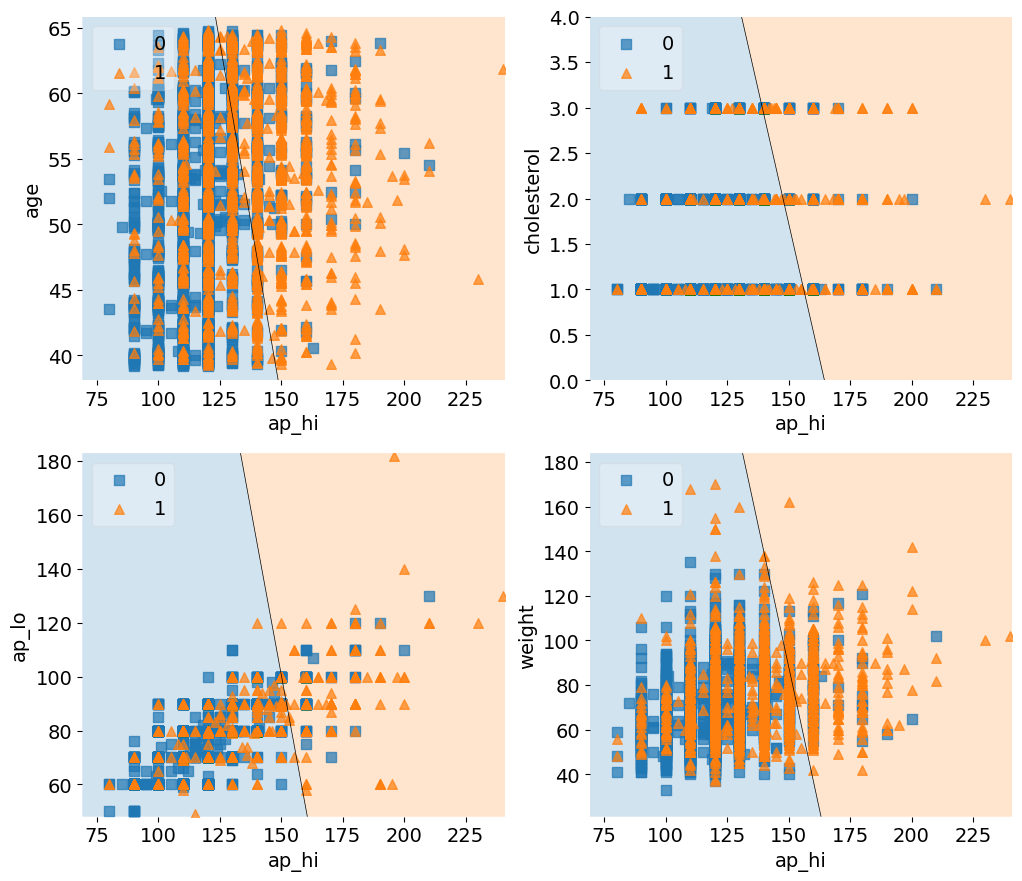

In [32]:
plt.rcParams.update({'font.size':14})
fig,axarr=plt.subplots(2,2,figsize=(12,8),sharex=True,sharey=False)
mldatasets.create_decision_plot(
    X_test,
    y_test,
    log_result,
    ["ap_hi","age"],
    None,
    X_highlight,
    filler_feature_values,
    ax=axarr.flat[0]
)
mldatasets.create_decision_plot(
    X_test,
    y_test,
    log_result,
    ['ap_hi','cholesterol'],
    None,
    X_highlight,
    filler_feature_values,
    ax=axarr.flat[1]
)
mldatasets.create_decision_plot(
    X_test,
    y_test,
    log_result,
    ["ap_hi", "ap_lo"],
    None,
    X_highlight,
    filler_feature_values,
    ax=axarr.flat[2],
)
mldatasets.create_decision_plot(
    X_test,
    y_test,
    log_result,
    ["ap_hi", "weight"],
    None,
    X_highlight,
    filler_feature_values,
    ax=axarr.flat[3],
)
plt.subplots_adjust(top=1,bottom=0,hspace=0.2,wspace=0.2)
plt.show()